Saving morphological_operations.png to morphological_operations (12).png


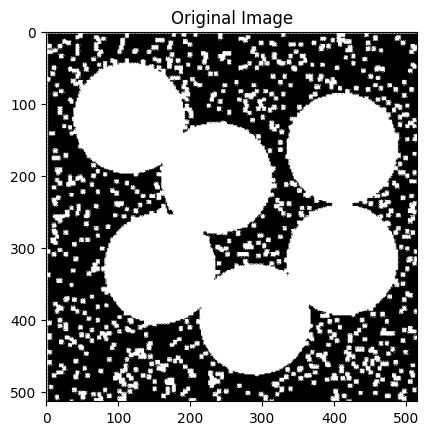

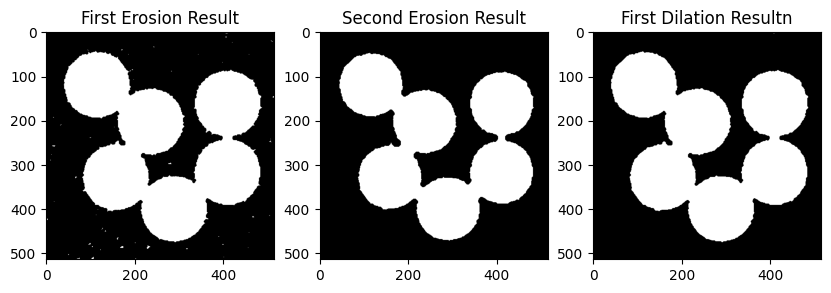

In [47]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

uploaded = files.upload()

for file_uploaded in uploaded.keys():
    org_img = Image.open(file_uploaded).convert('L')  # Convert image to grayscale
    img_array = np.array(org_img)  # Convert the image to a numpy array (matrix)

    # Convertion to binary using 128 as threshold
    binary_image = (img_array > 128).astype(np.uint8)  # Threshold at 128 to make it binary
    plt.imshow(binary_image, cmap='gray')
    plt.title('Original Image')
    plt.show()

    # 7x7 due to the circular shape and high noise ratio
    structuring_element = np.array([[0, 0, 1, 1, 1, 0, 0],
                                    [0, 1, 1, 1, 1, 1, 0],
                                    [1, 1, 1, 1, 1, 1, 1],
                                    [1, 1, 1, 1, 1, 1, 1],
                                    [1, 1, 1, 1, 1, 1, 1],
                                    [0, 1, 1, 1, 1, 1, 0],
                                    [0, 0, 1, 1, 1, 0, 0]], dtype=np.uint8)



def dilation(source_image, struct_elem):
    # Padding for correct result and padding as 0 since it does not corrupt the dilation process
    padding = struct_elem.shape[0] // 2
    img_padded = np.pad(source_image, padding, mode='constant', constant_values=0)
    dilated = np.zeros_like(source_image)

    # using the structuring element
    for i in range(source_image.shape[0]):
        for j in range(source_image.shape[1]):
            # Look for any 1 in neighborhood
            if np.any(struct_elem & img_padded[i:i + struct_elem.shape[0], j:j + struct_elem.shape[1]]):
                dilated[i, j] = 1
    return dilated

def erosion(source_image, struct_elem):
    # Padding for correct result and padding as 1 since it does not corrupt the erosion process
    pad = struct_elem.shape[0] // 2
    img_padded = np.pad(source_image, pad, mode='constant', constant_values=1)
    eroded = np.zeros_like(source_image)

    # Using the structuring elem
    for i in range(source_image.shape[0]):
        for j in range(source_image.shape[1]):
           # Look for all 1 in neighborhood
            if np.all(struct_elem == (img_padded[i:i + struct_elem.shape[0], j:j + struct_elem.shape[1]] & struct_elem)):
                eroded[i, j] = 1
    return eroded

erosion_first = erosion(binary_image, structuring_element)
erosion_second = erosion(erosion_first, structuring_element)

dilation_first = dilation(erosion_second, structuring_element)


# Display the results at each step
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(erosion_first, cmap='gray')
plt.title('First Erosion Result')

plt.subplot(1, 3, 2)
plt.imshow(erosion_second, cmap='gray')
plt.title('Second Erosion Result')

plt.subplot(1, 3, 3)
plt.imshow(dilation_first, cmap='gray')
plt.title('First Dilation Resultn')
plt.show()


Saving hist1.jpg to hist1 (4).jpg
Saving hist2.jpg to hist2 (4).jpg


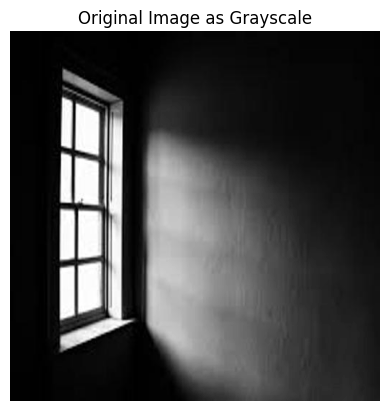

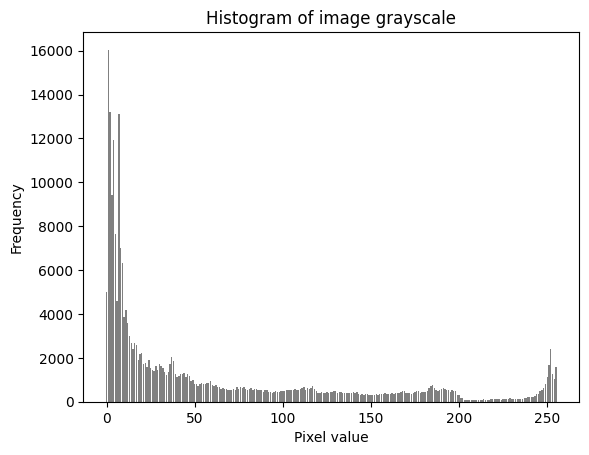

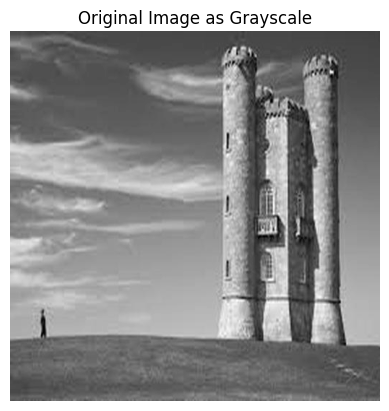

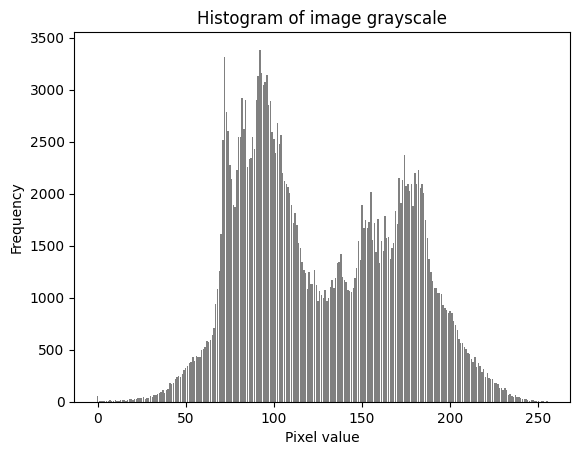

In [48]:
def histogram(source_image):
    # hist as array of 256 for grayscale, all initialized as 0
    hist = [0] * 256

    # calculating pixel
    for row in source_image:
        for pixel in row:
            hist[pixel] += 1

    return hist


uploaded = files.upload()

for uploaded_images in uploaded.keys():
    #Converting to binary
    image = Image.open(uploaded_images).convert('L')
    source_image = np.array(image)

    plt.imshow(source_image, cmap='gray', vmin=0, vmax=255)
    plt.title("Original Image as Grayscale")
    plt.axis('off')
    plt.show()

    hist_data = histogram(source_image)

    plt.bar(range(256), hist_data, color='gray')
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency')
    plt.title('Histogram of image grayscale')
    plt.show()

Saving contrastive_strecth.png to contrastive_strecth (12).png


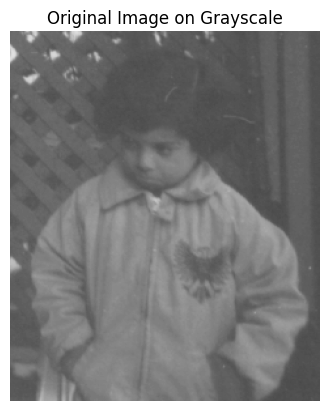

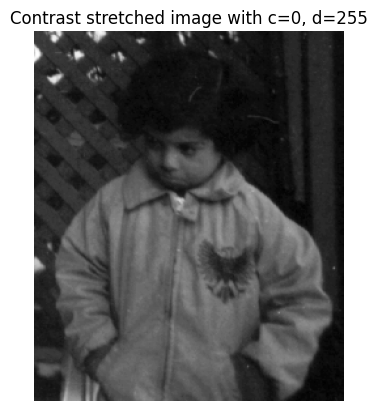

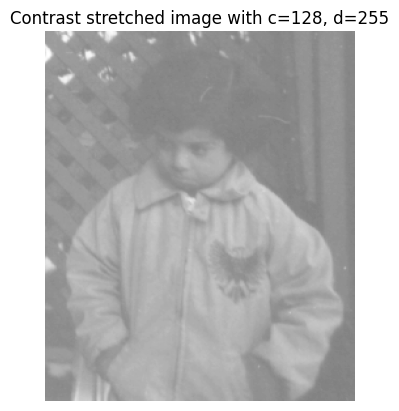

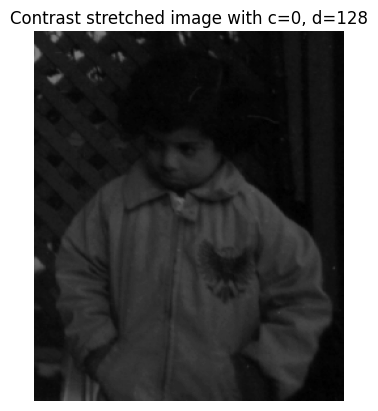

In [49]:
def contrast_stretching(source_image, c, d):
    # a for minimum intensity, b for max pixel intensity
    a = np.min(source_image)
    b = np.max(source_image)

    stretched = ((source_image - a)/ (b - a)) * ((d - c)) + c

    return stretched.astype(np.uint8)

# upload image
uploaded = files.upload()

for uploaded_images in uploaded.keys():
    image = Image.open(uploaded_images).convert('L')
    source_image = np.array(image)

# Original
plt.imshow(source_image, cmap='gray', vmin=0, vmax=255)
plt.title("Original Image on Grayscale")
plt.axis('off')
plt.show()

# wanted strecthing values c and d
stretch_vals = [(0, 255), (128, 255), (0, 128)]

# apply algorithm and display stretched with c d
for c, d in stretch_vals:
    stretched = contrast_stretching(source_image, c, d)
    plt.imshow(stretched, cmap='gray', vmin=0, vmax=255)
    plt.title(f"Contrast stretched image with c={c}, d={d}")
    plt.axis('off')
    plt.show()

Saving otsu_1.png to otsu_1 (5).png
Saving otsu_2.jpg to otsu_2 (5).jpg


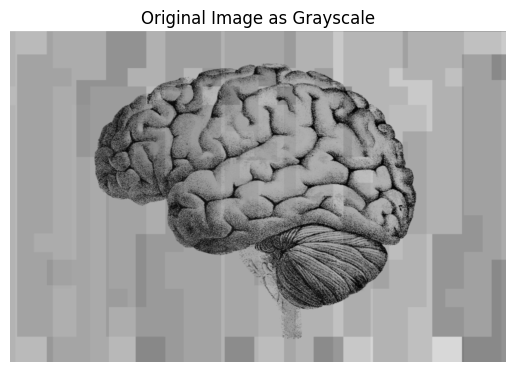

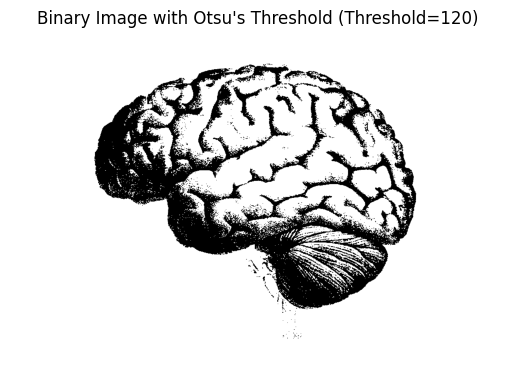

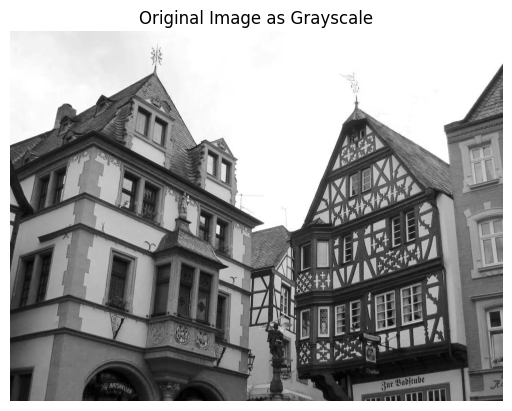

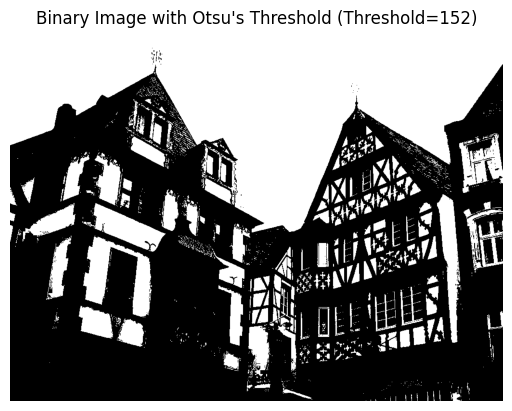

In [50]:

def otsu_threshold(source_image):
    # same with function histogram(source_image)
    hist = [0] * 256
    pixel_count = source_image.size
    for row in source_image:
        for pixel in row:
            hist[pixel] += 1

    prob = [h / pixel_count for h in hist]

    # Calculate cumulative sum which is pdf and mean using probability
    cdf = np.cumsum(prob)
    cumulative_mean = np.cumsum([i * prob[i] for i in range(256)])

    # Total mean found by the last element
    total_mean = cumulative_mean[-1]

    # Find the optimal threshold by minimizing weighted sum of within-class variances
    min_within_class_variance = float('inf')
    threshold = 0

    for x in range(256):
        # b for background and f for foreground, object
        #since there is 2 spikes and we try to evaluate the min point of the variance within the class
        W_b = cdf[x]
        # cdf is 1 in last element, so background is cdf and 1 - cdf is the foreground
        W_f = 1 - W_b

        # Directly skip if there isn't obvious separation
        if W_b == 0 or W_f == 0:
            continue

        # means of two separate part
        mean_b = cumulative_mean[x] / W_b if W_b > 0 else 0
        mean_f = (total_mean - cumulative_mean[x]) / W_f if W_f > 0 else 0

        # Within-class variances from 0 to x and from x+1 to 256
        variance_b = sum([(i - mean_b) ** 2 * prob[i] for i in range(x + 1)]) / W_b
        variance_f = sum([(i - mean_f) ** 2 * prob[i] for i in range(x + 1, 256)]) / W_f

        # Weighted sum of within-class variances
        within_class = W_b * variance_b + W_f * variance_f

        # Find the min
        if within_class < min_within_class_variance:
            min_within_class_variance = within_class
            threshold = x

    # Applying threshold to original image
    binary_image = (source_image >= threshold).astype(np.uint8) * 255
    return binary_image, threshold

uploaded = files.upload()

for file_name in uploaded.keys():
    # Convert to grayscale and array of NumPy
    img = Image.open(file_name).convert('L')
    source_image = np.array(img)

    # Original Image
    plt.imshow(source_image, cmap='gray', vmin=0, vmax=255)
    plt.title("Original Image as Grayscale")
    plt.axis('off')
    plt.show()

    binary_image, threshold = otsu_threshold(source_image)

    # Thresholded image
    plt.imshow(binary_image, cmap='gray', vmin=0, vmax=255)
    plt.title(f"Binary Image with Otsu's Threshold (Threshold={threshold})")
    plt.axis('off')
    plt.show()

Saving convolution_spatial_domain.jpg to convolution_spatial_domain (1).jpg


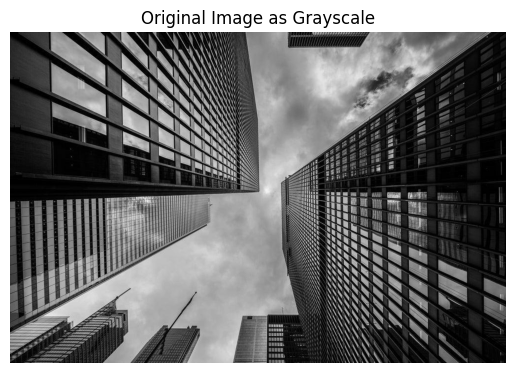

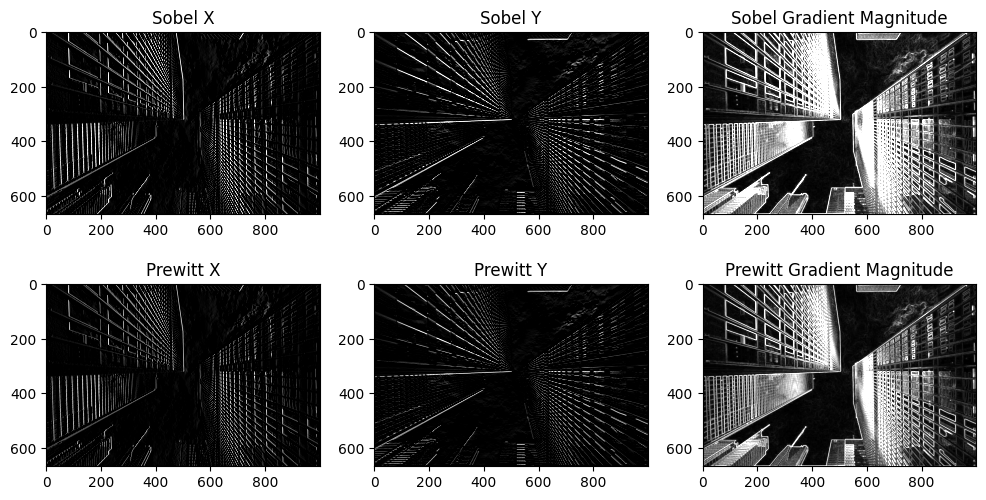

In [51]:
def convolve2d(image, kernel):
    # dimensions of image and kernel
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape

    # Padding sizes
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2

    image_padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

    # output array initialization
    convolved = np.zeros((image_h, image_w))

    # Convolution
    for i in range(image_h):
        for j in range(image_w):
            # Isolating the frame
            frame = image_padded[i:i+kernel_h, j:j+kernel_w]
            # multiply elements and sum to have output pixel value
            convolved[i, j] = np.sum(frame * kernel)

    return convolved

# Sobel and Prewitt
x_sobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
y_sobel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

x_prewitt = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
y_prewitt = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

uploaded = files.upload()

for file_name in uploaded.keys():
    img = Image.open(file_name).convert('L')  # Convert image to grayscale
    source_image = np.array(img)  # Convert the image to a numpy array (matrix)

# Original
plt.imshow(source_image, cmap='gray', vmin=0, vmax=255)
plt.title("Original Image as Grayscale")
plt.axis('off')
plt.show()

# Convolution for Sobel
sobel_x = convolve2d(source_image, x_sobel)
sobel_y = convolve2d(source_image, y_sobel)
sobel_result = np.sqrt(sobel_x**2 + sobel_y**2)  # Gradient magnitude

# Convolution for Prewitt
prewitt_x = convolve2d(source_image, x_prewitt)
prewitt_y = convolve2d(source_image, y_prewitt)
prewitt_result = np.sqrt(prewitt_x**2 + prewitt_y**2)  # Gradient magnitude

# Display finals
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(sobel_x, cmap='gray', vmin=0, vmax=255)
plt.title("Sobel X")

plt.subplot(2, 3, 2)
plt.imshow(sobel_y, cmap='gray', vmin=0, vmax=255)
plt.title("Sobel Y")

plt.subplot(2, 3, 3)
plt.imshow(sobel_result, cmap='gray', vmin=0, vmax=255)
plt.title("Sobel Gradient Magnitude")

plt.subplot(2, 3, 4)
plt.imshow(prewitt_x, cmap='gray', vmin=0, vmax=255)
plt.title("Prewitt X")

plt.subplot(2, 3, 5)
plt.imshow(prewitt_y, cmap='gray', vmin=0, vmax=255)
plt.title("Prewitt Y")

plt.subplot(2, 3, 6)
plt.imshow(prewitt_result, cmap='gray', vmin=0, vmax=255)
plt.title("Prewitt Gradient Magnitude")

plt.show()

Saving convolution_freq_domain.jpg to convolution_freq_domain (7).jpg


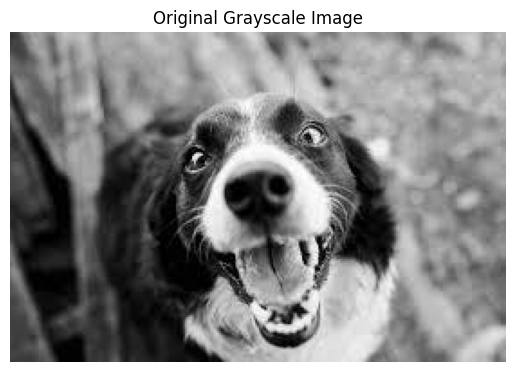

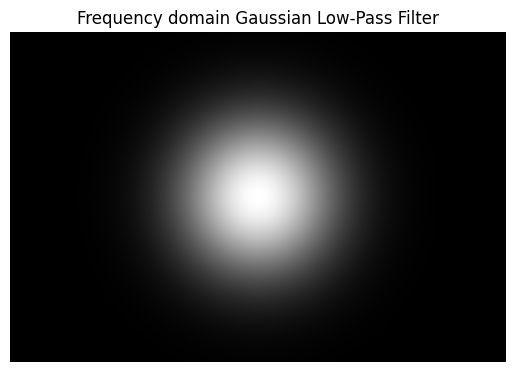

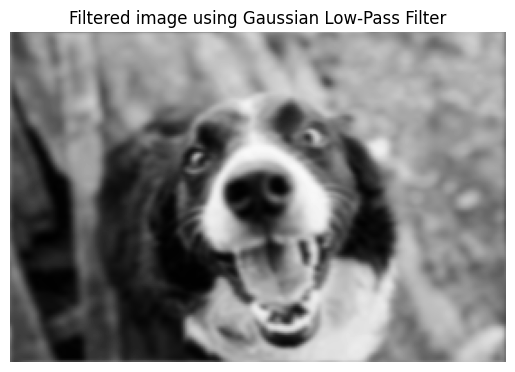

In [52]:
def gaussian_filter(shape, sigma):
    # Gaussian custom filter
    m, n = shape
    x_centered, y_centered = m // 2, n // 2

    # To calculate the distances from origin, applying a mesh
    x, y = np.ogrid[:m, :n]
    distance = (x - x_centered)**2 + (y - y_centered)**2
    gaussian = np.exp(-distance / (2 * sigma**2))
    return gaussian

def freq_filtering(original_image, sigma):
    # Transform to frequency domain using np
    image_freq = np.fft.fft2(original_image)
    # shift zero to center for spectrum
    image_freq_shifted = np.fft.fftshift(image_freq)

    # Gaussian call
    filter = gaussian_filter(original_image.shape, sigma)

    # Pixelwise multiply
    filtered_freq_image = image_freq_shifted * filter

    # Transform from freq back to original domain
    # Shifted back
    filtered_freq_image_shifted = np.fft.ifftshift(filtered_freq_image)
    # Transform back
    filtered_image = np.fft.ifft2(filtered_freq_image_shifted)
    # Magnitude for real representation
    filtered_image = np.abs(filtered_image)

    return filtered_image, filter

uploaded = files.upload()

for file_name in uploaded.keys():
    img = Image.open(file_name).convert('L')
    source_image = np.array(img)

# Original image
plt.imshow(source_image, cmap='gray', vmin=0, vmax=255)
plt.title("Original Grayscale Image")
plt.axis('off')
plt.show()

# Variance setting
sigma = 30

filtered_image, gaussian_filter = freq_filtering(source_image, sigma)

# Filter
plt.imshow(gaussian_filter, cmap='gray')
plt.title("Frequency domain Gaussian Low-Pass Filter")
plt.axis('off')
plt.show()

# Filtered image
plt.imshow(filtered_image, cmap='gray', vmin=0, vmax=255)
plt.title("Filtered image using Gaussian Low-Pass Filter")
plt.axis('off')
plt.show()